# Import Libraries 

import pandas as pd
import numpy as np
import sqlite3

pd.set_option("display.max_columns", None)


# Load dataset

In [5]:
df = pd.read_csv("synthetic_customer_churn_100k.csv")  # adjust filename if needed
df.head()


,CustomerID,Age,Gender,Tenure,MonthlyCharges,Contract,PaymentMethod,TotalCharges,Churn
0,1,56,Female,68,147.58,Two year,Bank transfer,10052.03,No
1,2,69,Male,32,22.54,Month-to-month,Mailed check,686.78,No
2,3,46,Female,10,52.47,One year,Electronic check,537.88,No
3,4,32,Male,22,109.67,Month-to-month,Mailed check,2390.04,Yes
4,5,60,Female,54,130.98,Month-to-month,Credit card,7081.28,No


# sanity checks

In [7]:
df.shape


(100000, 9)

In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   CustomerID      100000 non-null  int64  
 1   Age             100000 non-null  int64  
 2   Gender          100000 non-null  object 
 3   Tenure          100000 non-null  int64  
 4   MonthlyCharges  100000 non-null  float64
 5   Contract        100000 non-null  object 
 6   PaymentMethod   100000 non-null  object 
 7   TotalCharges    100000 non-null  float64
 8   Churn           100000 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 6.9+ MB


In [11]:
df.isna().sum().sort_values(ascending=False)


CustomerID        0
Age               0
Gender            0
Tenure            0
MonthlyCharges    0
Contract          0
PaymentMethod     0
TotalCharges      0
Churn             0
dtype: int64

# Clean data

In [19]:

if df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df.dropna(inplace=True)


In [21]:
df['Churn'].value_counts(normalize=True)


Churn
No     0.66856
Yes    0.33144
Name: proportion, dtype: float64

# Load into SQLite

In [24]:
conn = sqlite3.connect("churn.db")
df.to_sql("customers", conn, if_exists="replace", index=False)


100000

# SQL ANALYSIS

In [27]:
pd.read_sql("""
SELECT 
    Churn,
    COUNT(*) AS customers,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM customers), 2) AS percentage
FROM customers
GROUP BY Churn;
""", conn)


,Churn,customers,percentage
0,No,66856,66.86
1,Yes,33144,33.14


In [29]:
pd.read_sql("""
SELECT 
    Contract,
    COUNT(*) AS total_customers,
    ROUND(SUM(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END)*100.0 / COUNT(*), 2) AS churn_rate
FROM customers
GROUP BY Contract
ORDER BY churn_rate DESC;
""", conn)


,Contract,total_customers,churn_rate
0,Month-to-month,54915,46.56
1,Two year,19824,16.88
2,One year,25261,16.75


In [31]:
pd.read_sql("""
SELECT
    CASE 
        WHEN tenure < 12 THEN '0–1 year'
        WHEN tenure BETWEEN 12 AND 24 THEN '1–2 years'
        ELSE '2+ years'
    END AS tenure_group,
    COUNT(*) AS customers,
    ROUND(AVG(CASE WHEN Churn='Yes' THEN 1 ELSE 0 END)*100, 2) AS churn_rate
FROM customers
GROUP BY tenure_group;
""", conn)


,tenure_group,customers,churn_rate
0,0–1 year,15256,67.41
1,1–2 years,18028,26.86
2,2+ years,66716,27.01


In [33]:
pd.read_sql("""
SELECT
    Churn,
    ROUND(SUM(MonthlyCharges), 2) AS monthly_revenue
FROM customers
GROUP BY Churn;
""", conn)


,Churn,monthly_revenue
0,No,4870181.33
1,Yes,3127312.01


# import libraries 

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


# Churn Distribution 

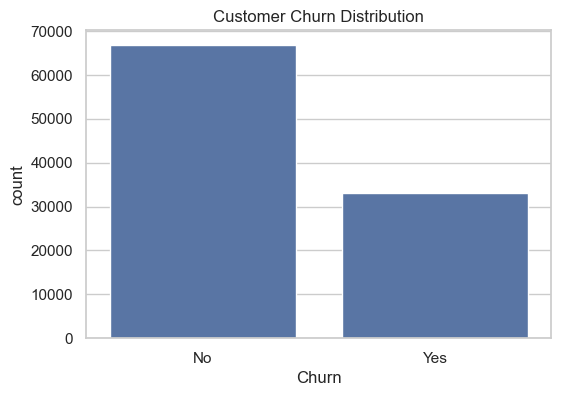

In [39]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Customer Churn Distribution")
plt.show()


Most customers do not churn, but the churned segment is large enough to significantly impact revenue.

# Monthly charges vs churn


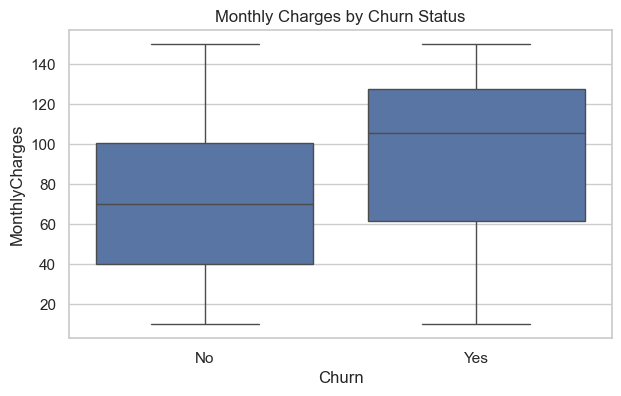

In [44]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn Status")
plt.show()


Customers who churn generally have higher monthly charges, indicating price sensitivity as a major churn factor.

# Tenure vs churn

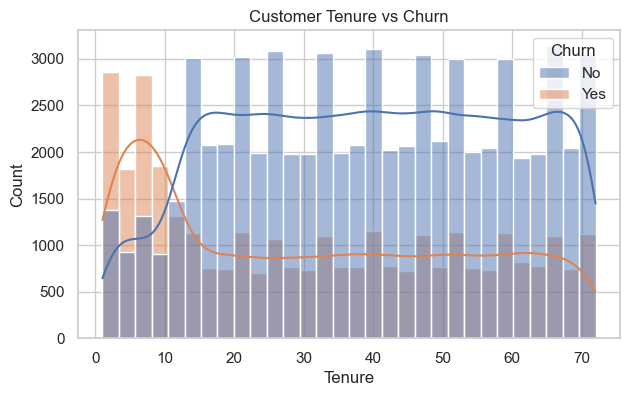

In [52]:
plt.figure(figsize=(7,4))
sns.histplot(df, x='Tenure', hue='Churn', bins=30, kde=True)
plt.title("Customer Tenure vs Churn")
plt.show()


Churn is concentrated among customers with lower tenure, suggesting early-stage engagement is critical for retention.

# Contract type impact

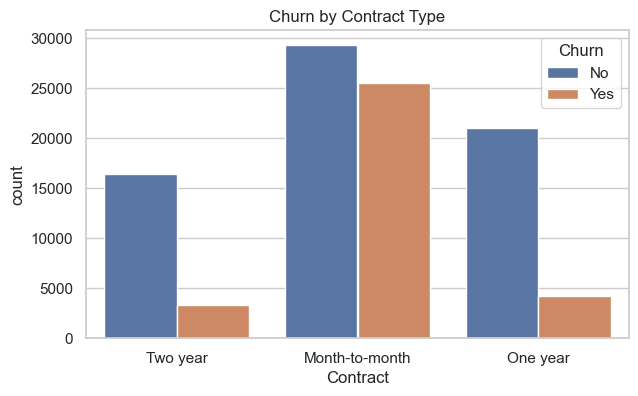

In [56]:
plt.figure(figsize=(7,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn by Contract Type")
plt.show()


Month-to-month contracts show significantly higher churn compared to long-term contracts.

# Correlation with churn

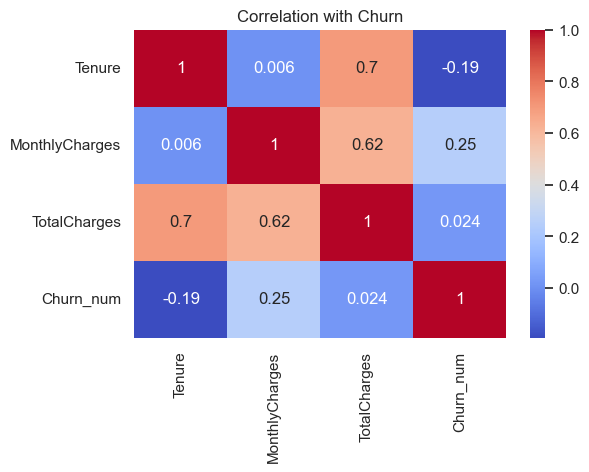

In [64]:
df['Churn_num'] = df['Churn'].map({'Yes': 1, 'No': 0})

corr = df[['Tenure', 'MonthlyCharges', 'TotalCharges', 'Churn_num']].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation with Churn")
plt.show()


In [66]:
df.to_csv("churn_eda_ready.csv", index=False)


# Can we predict which customers are likely to churn, and what factors contribute most to churn?

# Data Prepration

Create a modeling dataframe

In [74]:
model_df = df[[
    'Tenure',
    'MonthlyCharges',
    'TotalCharges',
    'Contract',
    'PaymentMethod',
    'Age',
    'Gender',
    'Churn_num'
]].copy()


Encode target variable

In [85]:
model_df = model_df.rename(columns={'Churn_num': 'Churn'})


Handle missing values

In [88]:
model_df['TotalCharges'] = pd.to_numeric(model_df['TotalCharges'], errors='coerce')
model_df = model_df.dropna()


Encode categorical variables

In [91]:
model_df = pd.get_dummies(
    model_df,
    columns=['Contract', 'PaymentMethod', 'Gender'],
    drop_first=True
)


# Train–Test Split

In [94]:
from sklearn.model_selection import train_test_split

X = model_df.drop('Churn', axis=1)
y = model_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


# Train Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

# Evaluation

In [100]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[[14262  2452]
 [ 4434  3852]]
              precision    recall  f1-score   support

           0       0.76      0.85      0.81     16714
           1       0.61      0.46      0.53      8286

    accuracy                           0.72     25000
   macro avg       0.69      0.66      0.67     25000
weighted avg       0.71      0.72      0.71     25000

ROC-AUC: 0.7712433329460191


# FEATURE IMPORTANCE (Logistic Regression)

In [104]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

feature_importance


,Feature,Coefficient
8,PaymentMethod_Mailed check,0.022230
9,Gender_Male,0.021506
10,Gender_Other,0.017504
7,PaymentMethod_Electronic check,0.015140
1,MonthlyCharges,0.012127
2,TotalCharges,0.000121
3,Age,-0.001090
6,PaymentMethod_Credit card,-0.014817
0,Tenure,-0.035157
5,Contract_Two year,-1.654603


# VISUALIZE TOP DRIVERS

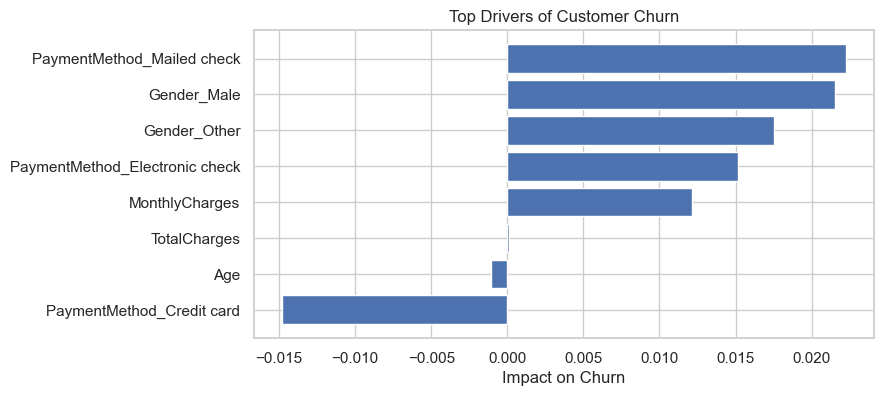

In [107]:
import matplotlib.pyplot as plt

top_features = feature_importance.head(8)

plt.figure(figsize=(8,4))
plt.barh(top_features['Feature'], top_features['Coefficient'])
plt.title("Top Drivers of Customer Churn")
plt.xlabel("Impact on Churn")
plt.gca().invert_yaxis()
plt.show()


# PROFILE HIGH-RISK CUSTOMERS

In [110]:
high_risk = X_test[y_prob > 0.7]

high_risk[['Tenure', 'MonthlyCharges', 'Age']].describe()


,Tenure,MonthlyCharges,Age
count,1571.000000,1571.000000,1571.000000
mean,14.353278,130.792801,47.478676
std,10.246109,14.021508,18.173089
min,1.000000,86.400000,18.000000
25%,6.000000,120.835000,31.000000
50%,12.000000,133.490000,47.000000
75%,21.000000,142.615000,63.000000
max,46.000000,150.000000,80.000000


In [112]:
X_test[['Tenure', 'MonthlyCharges', 'Age']].describe()


,Tenure,MonthlyCharges,Age
count,25000.000000,25000.000000,25000.00000
mean,36.489360,80.185808,49.00052
std,20.771117,40.392939,18.18493
min,1.000000,10.020000,18.00000
25%,18.750000,44.860000,33.00000
50%,37.000000,80.310000,49.00000
75%,55.000000,115.272500,65.00000
max,72.000000,150.000000,80.00000


### Business Insights & Recommendations

The churn model indicates that customers with shorter tenure and higher monthly charges are significantly more likely to churn. 
Month-to-month contracts emerge as the strongest churn driver, suggesting limited customer commitment.

**Recommended actions:**
- Introduce targeted discounts for high-risk, short-tenure customers.
- Incentivize upgrades to long-term contracts.
- Proactively engage customers with rising monthly charges before churn occurs.
